# ML4SCI Task

This notebook demonstrates the model trained on data provided for **Specific Task 2: Lens Finding**

## WorkFlow
- Load the data created in the notebook `DeepLense_EDA`
- Define `Dataset` class 
- Define `pretrained Model` class which uses **Transfer Learning** 
- Define `train_utils` class having loss, optimizer, scheduler, score function
- Define `Train` class having function for training, validation and training_loop
- `CFG` class is used to set the hyperparamters 

In [1]:
# Importing necesaary library
import os
import numpy as np
import pandas as pd
import h5py
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from timm.scheduler import CosineLRScheduler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
# Loading csv file
data_df = pd.read_csv('/kaggle/input/deeplense-2/DeepLense/classifications.csv')
data_df.head(10)

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma,image_path
0,100000,1,8.633760e-10,171,195.429,/kaggle/input/deeplense-2/DeepLense/images/100...
1,100001,1,1.317890e-10,294,855.589,/kaggle/input/deeplense-2/DeepLense/images/100...
2,100002,1,4.877250e-12,140,486.113,/kaggle/input/deeplense-2/DeepLense/images/100...
3,100003,1,1.440160e-09,1500,10467.400,/kaggle/input/deeplense-2/DeepLense/images/100...
4,100004,0,2.197350e-11,0,0.000,/kaggle/input/deeplense-2/DeepLense/images/100...
5,100005,0,2.804930e-10,0,0.000,/kaggle/input/deeplense-2/DeepLense/images/100...
6,100006,0,2.261430e-10,0,0.000,/kaggle/input/deeplense-2/DeepLense/images/100...
7,100007,1,1.466810e-10,213,829.363,/kaggle/input/deeplense-2/DeepLense/images/100...
8,100008,1,5.512840e-11,812,9446.660,/kaggle/input/deeplense-2/DeepLense/images/100...
9,100009,0,1.608170e-09,0,0.000,/kaggle/input/deeplense-2/DeepLense/images/100...


In [3]:
# Checking if the path is correct or not
data_df['image_path'][0]

'/kaggle/input/deeplense-2/DeepLense/images/100000.npy'

In [4]:
# Number of negative examples
len(data_df[data_df['is_lens']==0])

5426

In [5]:
# Configuration class
class CFG:
    lr = 0.0001
    batch_size = 64
    num_classes = 1
    size=[224, 224]
    nfold = 10
    custom_model=False
    model_name = "tf_efficientnet_b2_ns"
    target_col="is_lens"
    epochs = 10
    seed = 42
    transform = False
    weight_decay = 1e-2
    num_workers=2
    train=True
    debug=False
    metric_type="roc_auc"
    scheduler_type = "CosineLRScheduler"
    optimizer_type = "Adam"
    loss_type = "BCEWithLogitsLoss"
    is_cross_validate = True
    max_grad_norm = 1000
    lr_max = 4e-4
    epochs_warmup = 1.0
    pos_weight = 5
    meta_count = 3

Keeping `n_fold` = 10 so that data distribution between training and validation follows 90:10 ratio

In [6]:
# If debug mode is true data is truncated to have only 100 images
if CFG.debug:
    data_df = data_df[:100]

In [7]:
# Augmentation
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(*CFG.size),
            A.Rotate(limit=20),
#             A.RandomBrightness (limit=0.1, always_apply=False, p=0.5),
#             A.RandomContrast (limit=(0.9, 1.1), always_apply=False, p=0.5),
            A.ShiftScaleRotate(rotate_limit=15, scale_limit = [0.8, 1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(
                mean = 0,
                std = 1,
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(*CFG.size),
            A.Normalize(
                mean = 0,
                std = 1,
            ),
            ToTensorV2(),
        ])

In [8]:
# PyTorch DataSet
class Dataset(nn.Module):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform
        self.metadata = self._prepare_meta()
        
    def _prepare_meta(self):
        data = self.df.drop(['ID', 'is_lens', 'image_path'], axis=1)
        # Scaling of MetaData
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        return data
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df['image_path']
        image = np.load(image_path.iloc[idx]).astype(np.float32)
        label = self.df['is_lens'].iloc[idx].astype(np.float32)
        
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image'] 
        meta = self.metadata[idx]
        return torch.tensor(image), meta, torch.tensor(label)

In [9]:
# Checking Dataset class
data = Dataset(data_df, transform = get_transforms(data='train'))
image_0, meta_0, label_0 = data[0]
image_1, meta_1, label_1 = data[1]
print('image shape:', image_0.shape, ', label:', label_0)
print('image shape:', image_1.shape, ', label:', label_1)

image shape: torch.Size([1, 224, 224]) , label: tensor(1.)
image shape: torch.Size([1, 224, 224]) , label: tensor(1.)


In [10]:
meta_0 

array([ 1.1200566 , -0.27495691, -0.15109305])

Text(0.5, 1.0, 'label = 1.0')

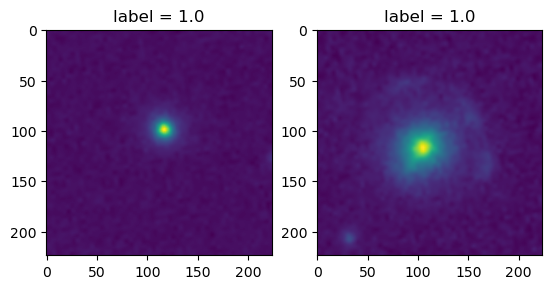

In [11]:
# Plotting few data
plt.subplot(1,2,1)
plt.imshow(image_0.permute(1, 2, 0))
plt.title("label = {}".format(label_0))
plt.subplot(1, 2, 2)
plt.imshow(image_1.permute(1, 2, 0))
plt.title("label = {}".format(label_1))

In [12]:
# Utility class
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
# Custom CNN Model
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, CFG.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
# Pretrained model class
class PretrainedModel(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.pretrained = pretrained
        self.model = timm.create_model(self.model_name, pretrained=self.pretrained, in_chans=1)
        clsf = self.model.default_cfg['classifier']
        n_features = self.model._modules[clsf].in_features
        self.model._modules[clsf] = nn.Identity()
        self.fc1 = nn.Linear(n_features, 1024)
        # Layer for meta data
        self.meta_model = nn.Sequential(nn.Linear(CFG.meta_count, 256),
                                        nn.BatchNorm1d(256),
                                        nn.Dropout(p=0.2),
                                        nn.ReLU(),
                                        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024 + 256, CFG.num_classes)
        
    def forward(self, x, meta):
        x = self.model(x)
        x = self.fc1(x)
        meta = self.meta_model(meta)
        out = torch.cat((x, meta), dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [15]:
# Class containing loss, optimizer, scheduler and score method
class train_utils():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG
    
    # Defining the Loss Function
    @property
    def get_criterion(self):
        if self.CFG.loss_type == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif self.CFG.loss_type == "BCEWithLogitsLoss":
            pos_weight = torch.Tensor([CFG.pos_weight]).to(device)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        return criterion
    
    # Defining the Score Function
    def get_score(self, y_true, y_pred):
        if self.CFG.metric_type == "accuracy_score":
            score =  accuracy_score(y_true, y_pred)
        elif self.CFG.metric_type == "roc_auc":
            score =  roc_auc_score(y_true, y_pred)
        return score
    
    # Defining the Optimizer Function
    def get_optimizer(self, model):
        if self.CFG.optimizer_type == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay, amsgrad=False)
        if self.CFG.optimizer_type == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay)
        return optimizer
    
    # Defining the Scheduler Function
    def get_scheduler(self, optimizer, warmup, nsteps):
        if self.CFG.scheduler_type == "StepLR":
            scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)
        if self.CFG.scheduler_type == 'CosineLRScheduler':
            scheduler = CosineLRScheduler(optimizer,
                                          warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True,
                                          t_initial=(nsteps - warmup), lr_min=1e-6)
        return scheduler

In [16]:
class Train():
    def __init__(self, CFG):
        super().__init__()
        self.CFG = CFG
        
    def train_fn(self, train_loader, model, criterion, optimizer, epoch, scheduler, device):
        model.train() # switch to training mode
        nbatch = len(train_loader)
        running_loss = AverageMeter()
        tb = time.time()

        pbar = tqdm(train_loader, total=len(train_loader))
        pbar.set_description(f"[{epoch+1}/{CFG.epochs}] Train")

        for ibatch, (images, meta, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            meta = meta.to(device)
            bs = images.size(0)
            y_preds = model(images, meta.float())
            loss = criterion(y_preds.view(-1), labels)
            running_loss.update(loss.item(), bs)

            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), self.CFG.max_grad_norm)
            optimizer.step()
            scheduler.step(epoch * nbatch + ibatch + 1)
#             scheduler.step()
            optimizer.zero_grad()

        lr_now = optimizer.param_groups[0]['lr']
        dt = (time.time()-tb)/60
        train_dict = {'loss': running_loss.avg,
                         'lr_now': lr_now,
                         'time': dt}

        return train_dict
    
    def valid_fn(self, valid_loader, model, criterion, device, train_obj, compute_score=True):
    
        tb = time.time() 
        model.eval() # switch to evaluation mode
        preds = []
        y_all = []
        running_loss = AverageMeter()

        pbar = tqdm(valid_loader, total=len(valid_loader))
        pbar.set_description("Validation")

        for images, meta, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            meta = meta.to(device)
            bs = images.size(0)
            # compute loss
            with torch.no_grad():
                y_preds = model(images, meta.float())
            loss = criterion(y_preds.view(-1), labels)
            running_loss.update(loss.item(), bs)
            # record accuracy
            y_all.append(labels.cpu().detach().numpy())
            preds.append(y_preds.sigmoid().to('cpu').numpy())
            

        del loss, images, labels, y_preds

        y_ground = np.concatenate(y_all)
        y_pred = np.concatenate(preds)
        score = train_obj.get_score(y_ground, y_pred) if compute_score else None 
        val_loss = running_loss.avg

        val_dict = {'loss': val_loss,
                   'score': score,
                   'y': y_ground,
                   'y_pred': y_pred,
                    'time': (time.time() - tb)/60
                   }

        return val_dict
    
    # Train loop
    def train_loop(self, data):

        if self.CFG.is_cross_validate:

            kfold = StratifiedKFold(n_splits=self.CFG.nfold, random_state=42, shuffle=True)
            for ifold, (idx_train, idx_test) in enumerate(kfold.split(data, data['is_lens'])):

                print('Fold %d/%d' %(ifold, self.CFG.nfold))
                torch.manual_seed(self.CFG.seed + ifold + 1)
                # create dataset
                train_dataset = Dataset(data.iloc[idx_train], transform=get_transforms(data='train'))
                valid_dataset = Dataset(data.iloc[idx_test], transform=get_transforms(data='valid'))

                # create dataloaider
                train_loader = DataLoader(train_dataset, batch_size=self.CFG.batch_size, shuffle=True, 
                                          num_workers=self.CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset, batch_size=self.CFG.batch_size, shuffle=False, 
                                          num_workers=self.CFG.num_workers, pin_memory=True, drop_last=False)

                # create model and transfer to device
                if CFG.custom_model:
                    model = ConvNeuralNet()
                else:
                    model = PretrainedModel(pretrained=True)
                model.to(device)
                
                # Creating object of train_utils
                train_obj = train_utils(self.CFG)
                # select optimizer, scheduler and criterion
                optimizer = train_obj.get_optimizer(model)
                nbatch = len(train_loader)
                warmup = self.CFG.epochs_warmup*nbatch
                nsteps = self.CFG.epochs*nbatch
                scheduler = train_obj.get_scheduler(optimizer, warmup, nsteps)
                criterion = train_obj.get_criterion

                time_val = 0.0
                tb = time.time()
                # start training
                for epoch in range(self.CFG.epochs):
                    # train
                    train_dict = self.train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
                    # validation
                    val_dict = self.valid_fn(valid_loader, model, criterion, device, train_obj)

                    time_val += val_dict['time']

                    print('Epoch = %d train_loss = %.4f val_score = %.4f lr = %.2e time = %.2f min' % (epoch+1, train_dict['loss'], 
                                                                     val_dict['score'], train_dict['lr_now'], train_dict['time']))
                dt = (time.time() - tb)/60
                print('Training done %.2f min total, %.2f min val'% (dt, time_val))

                output_file = 'model%d.pytorch'%ifold
                torch.save(model.state_dict(), output_file)
                print(output_file, 'written')
                break # Train single fold
            return val_dict

In [17]:
# main
def main():
    if CFG.train: 
        # train
        train = Train(CFG)
        result = train.train_loop(data_df)
    return result

In [18]:
torch.cuda.empty_cache()
import gc
gc.collect()

50

In [19]:
if __name__ == "__main__":
    val_res = main()

Fold 0/10


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_ns-00306e48.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_ns-00306e48.pth
Validation: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]


Epoch = 1 train_loss = 1.0814 val_score = 0.9602 lr = 4.00e-04 time = 1.79 min


Validation: 100%|██████████| 29/29 [00:02<00:00, 10.58it/s]


Epoch = 2 train_loss = 0.7967 val_score = 0.9733 lr = 3.88e-04 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:02<00:00, 10.14it/s]


Epoch = 3 train_loss = 0.7157 val_score = 0.9736 lr = 3.53e-04 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:02<00:00, 10.86it/s]


Epoch = 4 train_loss = 0.6856 val_score = 0.9725 lr = 3.00e-04 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:02<00:00, 10.24it/s]


Epoch = 5 train_loss = 0.6674 val_score = 0.9731 lr = 2.35e-04 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:02<00:00, 10.69it/s]


Epoch = 6 train_loss = 0.6657 val_score = 0.9735 lr = 1.66e-04 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:03<00:00,  9.58it/s]


Epoch = 7 train_loss = 0.6520 val_score = 0.9748 lr = 1.01e-04 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:03<00:00,  9.57it/s]


Epoch = 8 train_loss = 0.6443 val_score = 0.9725 lr = 4.77e-05 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:02<00:00, 10.89it/s]


Epoch = 9 train_loss = 0.6313 val_score = 0.9731 lr = 1.30e-05 time = 1.69 min


Validation: 100%|██████████| 29/29 [00:03<00:00,  9.39it/s]


Epoch = 10 train_loss = 0.6425 val_score = 0.9743 lr = 1.00e-06 time = 1.69 min
Training done 17.53 min total, 0.55 min val
model0.pytorch written


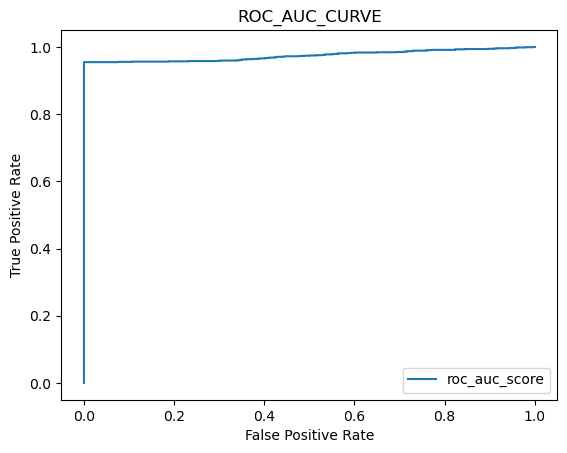

In [20]:
fpr, tpr, _ = roc_curve(val_res['y'],  val_res['y_pred'], pos_label=1)

#create ROC curve
plt.plot(fpr,tpr, label='roc_auc_score')
plt.title("ROC_AUC_CURVE")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

<AxesSubplot:>

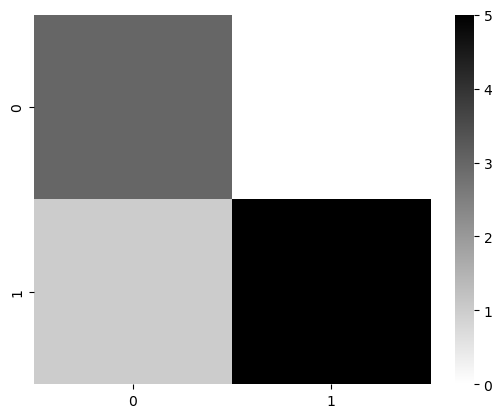

In [22]:
# Plotting Confusion Matrix
m = confusion_matrix(val_res['y'], val_res['y_pred']>0.5)
sns.heatmap(m, cmap='binary')

# Future Work
- Try various other data augmentation
- Try Focal loss
- Try transformer as backbone
- Try self-supervised kind of training